In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input

In [2]:
data = pd.read_csv('racoon-data/train_labels_.csv')
data

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127
...,...,...,...,...,...,...,...,...
168,raccoon-137.jpg,320,240,raccoon,71,8,304,233
169,raccoon-171.jpg,224,225,raccoon,108,21,180,115
170,raccoon-190.jpg,259,194,raccoon,78,54,153,135
171,raccoon-22.jpg,640,360,raccoon,252,76,466,335


In [29]:
# Required Information
IMAGE_DIR = 'racoon-data\\images\\Racoon Images\\images\\'

target = 216
target_size = (216, 216)

# Image Directory
image_path = os.path.join(os.getcwd(), IMAGE_DIR)

# Needed Lists for the images
images = []
targets = []
labels = []
missing_images = []

# Classes
classes = ['no raccoon', 'raccoon']

In [30]:
# Iterating through the Data Frame
for index, row in data.iterrows():
    
    # Converging Rows into Specific Data
    (filename, width, height, class_name, xmin, ymin, xmax, ymax)  = row

    try:
        # Finding Image Path 
        image_fullpath = os.path.join(image_path, filename)

        # Resizing Images to Target Size
        img = keras.preprocessing.image.load_img(image_fullpath, target_size=target_size)

        # Turning Images to Array
        img_arr = keras.preprocessing.image.img_to_array(img)

        # Adds Training Images
        images.append(img_arr)

        # Adds Training Targets also Normalizing for Region-Based CNN
        targets.append(((xmin / width) * (target / width), # Top Left X
                             (ymin / height) * (target / height), # Top Left Y
                             (xmax / width) * (target / width),  # Bottom Right X
                             (ymax / height) * (target / height))) # Bottom Right X
        
        # Adding Labels for Training Classification 
        labels.append(classes.index(class_name))

    except FileNotFoundError:
        # Catches the filenames that do not have an image within the image file
        missing_images.append(filename)

In [31]:
# Splitting data into train and test
index = int(len(data) * 0.7)

# 70% 
train_images = np.array(images[:index])
train_targets = np.array(targets[:index])
train_labels = np.array(labels[:index])

# 30%
validation_images = np.array(images[index:])
validation_targets = np.array(targets[index:])
validation_labels = np.array(labels[index:])

In [33]:
# Preprocessing Requirements
width = 216
height = 216
num_classes = 2

In [34]:
# Creating Input Layer for Model
input_shape = (width, height, 3)
input_layer = Input(shape=input_shape)

base_layers = layers.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

In [35]:
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)

In [36]:
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [37]:
model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])

losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

model.compile(loss=losses, optimizer='Adam', metrics=['accuracy', 'accuracy'])

In [38]:
EPOCHS = 12
BATCH_SIZE = 4

In [39]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

In [41]:
model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             shuffle=True,
             verbose=1)

Epoch 1/12
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - bb_head_accuracy: 0.6863 - bb_head_loss: 0.0712 - cl_head_accuracy: 0.8731 - cl_head_loss: 0.1044 - loss: 0.1757 - val_bb_head_accuracy: 0.8077 - val_bb_head_loss: 0.0417 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 3.4490e-04 - val_loss: 0.0421
Epoch 2/12
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - bb_head_accuracy: 0.8732 - bb_head_loss: 0.0436 - cl_head_accuracy: 1.0000 - cl_head_loss: 1.8728e-05 - loss: 0.0436 - val_bb_head_accuracy: 0.7500 - val_bb_head_loss: 0.0468 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 1.0863e-05 - val_loss: 0.0468
Epoch 3/12
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - bb_head_accuracy: 0.8189 - bb_head_loss: 0.0404 - cl_head_accuracy: 1.0000 - cl_head_loss: 3.1462e-06 - loss: 0.0404 - val_bb_head_accuracy: 0.8077 - val_bb_head_loss: 0.0517 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 1.7285e-06 - val_loss: 0.0517
Epoch 4/12
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - bb_head_accuracy: 0.8826

In [67]:
validation_img = 'racoon-data\\images\\Racoon Images\\images\\raccoon-25.jpg'

img = keras.preprocessing.image.load_img(validation_img)
# w, h = img.size
img = img.resize(target_size)
img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)

predictions = model.predict(img)
print(predictions)
print(predictions[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
[array([[-11.727732,  11.651264]], dtype=float32), array([[0.07305928, 0.10101886, 0.6450765 , 0.89296925]], dtype=float32)]
[[0.07305928 0.10101886 0.6450765  0.89296925]]


In [68]:
normalized_bounding_boxes = predictions[1]
normalized_bounding_boxes[0].tolist()

[0.07305928319692612,
 0.10101886093616486,
 0.6450765132904053,
 0.8929692506790161]

In [69]:
bounding_boxes = []
  
xmin, ymin, xmax, ymax = normalized_bounding_boxes[0].tolist()

x1 = round(xmin * width, 2)
y1 = round(ymin * height, 2)
x2 = round(xmax * width, 2)
y2 = round(ymax * height, 2)

bounding_boxes.append([x1, y1, x2, y2])
bounding_boxes

[[15.78, 21.82, 139.34, 192.88]]

In [70]:
from PIL import Image, ImageDraw

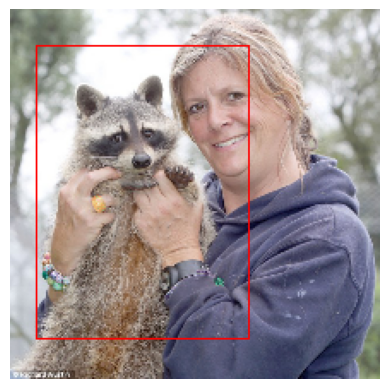

In [71]:
bounded_image = Image.open(validation_img)
bounded_image = cv2.resize(np.array(bounded_image), target_size)

bounded_image = Image.fromarray(bounded_image)

draw = ImageDraw.Draw(bounded_image)

draw.rectangle(bounding_boxes[0], outline='red', width=1)

plt.imshow(bounded_image)
plt.axis('off')
plt.show()